In [1]:
# Import required packages
from os import path 
import time
from datetime import datetime
import numpy as np
import pandas as pd
import torch
from torch import nn, Tensor
from torch.optim import AdamW
from tqdm import tqdm, trange
import zuko
from zuko.flows import Distribution, NSF
from zuko.distributions import DiagNormal, BoxUniform, Minimum
from zuko.flows import DistributionModule, FlowModule, Unconditional
from hnne import HNNE

from utils.settings import config
from utils.utils import *
from utils.model import *
from utils.robot import Robot
from utils.dataset import create_dataset

In [3]:
panda = Robot(verbose=False)
# data generation
X, y = load_data(robot=panda)
# build dimension reduction model
hnne, ds, loader = get_hnne_model(X, y)
# Build Generative model, NSF
# Neural spline flow (NSF) with 3 sample features and 5 context features
flow, optimizer, scheduler = get_flow_model()

hnne load successfully from ./weights/hnne.pickle
Finding nearest centroids to new data...
Setting up once a knn index for the last level centroids...
Tue May 23 14:33:07 2023 Building RP forest with 32 trees
Tue May 23 14:33:09 2023 NN descent for 19 iterations
	 1  /  19
	 2  /  19
	Stopping threshold met -- exiting after 2 iterations
Tue May 23 14:34:29 2023 Worst tree score: 0.94756640
Tue May 23 14:34:29 2023 Mean tree score: 0.94826018
Tue May 23 14:34:29 2023 Best tree score: 0.94890674
Tue May 23 14:34:31 2023 Forward diversification reduced edges from 20009880 to 6167081
Tue May 23 14:34:31 2023 Reverse diversification reduced edges from 6167081 to 6167081
Tue May 23 14:34:31 2023 Degree pruning reduced edges from 6697860 to 6697860
Tue May 23 14:34:31 2023 Resorting data and graph based on tree order
Tue May 23 14:34:32 2023 Building and compiling search function
Projecting data...
Model load successfully from ./weights/nsf.pth


,l2_err,log_prob
count,2400.000000,2400.000000
mean,0.006581,-9.405962
std,0.012701,2.052080
min,0.000338,-14.202006
25%,0.002965,-10.853506
50%,0.004610,-9.722914
75%,0.006944,-8.239238
max,0.265855,0.880608


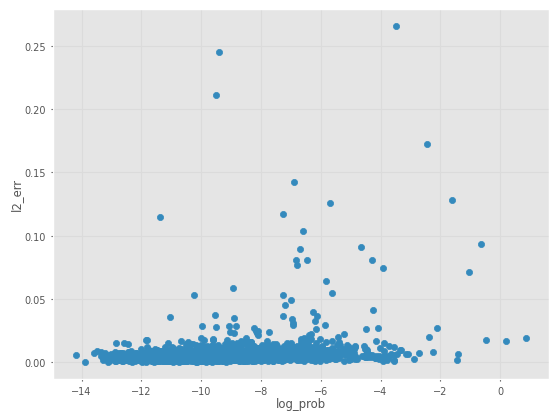

In [4]:
df, err = test_l2_err(config, robot=panda, loader=loader, model=flow)
ax1 = df.plot.scatter(x='log_prob', y='l2_err')
df.describe()

,l2_err,log_prob
count,2400.000000,2400.000000
mean,0.005676,-13.984208
std,0.008811,1.098563
min,0.000208,-16.978479
25%,0.002572,-14.694010
50%,0.004031,-14.170993
75%,0.006187,-13.469451
max,0.162211,-5.543342


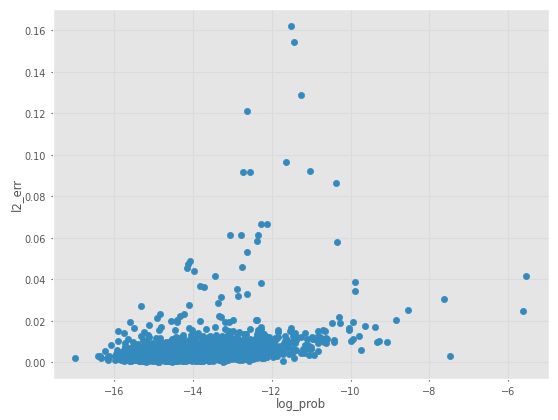

In [5]:
nflow = get_nflow_model(flow=flow)
df, err = test_l2_err(config, robot=panda, loader=loader, model=nflow)
ax1 = df.plot.scatter(x='log_prob', y='l2_err')
df.describe()

In [46]:
generate_new = True
 
traj_dir = config.traj_dir + datetime.now().strftime('%m%d%H%M') + '/'
ee_traj_path = traj_dir + 'ee_traj.npy'
q_traj_path = traj_dir + 'q_traj.npy'

if not generate_new and path.exists(path=q_traj_path):
    ee_traj = load_numpy(file_path=ee_traj_path)
    q_traj = load_numpy(file_path=q_traj_path)
else:
    ee_traj, q_traj = panda.path_generate_via_stable_joint_traj(dist_ratio=0.9, t=20)
    save_numpy(file_path=ee_traj_path, arr=ee_traj)
    save_numpy(file_path=q_traj_path, arr=q_traj)

100%|██████████| 20/20 [00:00<00:00, 15756.21it/s]

mkdir ./data/trajectory/05231707


In [47]:
num_traj = 3
rand = np.random.randint(low=0, high=len(q_traj), size=num_traj)
pidx = hnne.transform(X=q_traj[rand])
pidx

array([[-1.35489216, -0.44877287, -0.7785531 ,  0.29536053],
       [-0.22975776, -0.58198573,  0.30859385,  0.48558931],
       [-1.35939817, -0.4307186 , -0.77051118,  0.2951554 ]])

In [48]:
for i, px in enumerate(pidx):
    df, qs = sample_jtraj(ee_traj, px, nflow)
    print(df.describe())
    save_numpy(file_path=traj_dir + f'/exp_{i}.npy', arr=qs)

          l2_err   log_prob
count  20.000000  20.000000
mean    0.004280 -14.729406
std     0.002386   0.870248
min     0.000798 -15.946003
25%     0.002485 -15.191445
50%     0.003705 -14.925140
75%     0.005952 -14.559724
max     0.010591 -12.246136
          l2_err   log_prob
count  20.000000  20.000000
mean    0.005203 -13.661718
std     0.004584   1.723907
min     0.001470 -15.885427
25%     0.002419 -14.943780
50%     0.003361 -13.905260
75%     0.005251 -12.872104
max     0.018935  -9.752435
          l2_err   log_prob
count  20.000000  20.000000
mean    0.004061 -14.527898
std     0.001549   0.766943
min     0.001295 -15.748295
25%     0.002671 -15.060972
50%     0.004026 -14.543785
75%     0.005050 -14.208925
max     0.007070 -12.846766


In [49]:
ee_traj = load_numpy(file_path=ee_traj_path)
err = np.zeros((100,))

for i in range(3):
    step = 0
    qs = load_numpy(file_path=traj_dir + f'/exp_{i}.npy')
    for i in range(len(qs)):
        err[i] = panda.dist_fk(q=qs[i], ee_pos=ee_traj[i])
    outliner = np.where(err > 0.05)
    print(outliner)
    print(err[outliner])
    print(np.sum(err))
    panda.plot_qs(qs)

(array([], dtype=int64),)
[]
0.08560259922450161
(array([], dtype=int64),)
[]
0.10406966966654146
(array([], dtype=int64),)
[]
0.0812243886422167
